# Prévision des prix des voitures

### 1.4 Importation de bibliothèques

In [91]:
import re
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Normalization, Dense, Input, ReLU, Dropout
import matplotlib.pyplot as plt

### Parametres

In [72]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO =0.2
EURO_PARITY = 667,96

### Definition fonction

In [43]:
def clean_numeric_string(value):
    """
    Supprime tous les caractères non numériques d'une chaîne de caractères.
    Si la chaîne devient vide après le nettoyage, retourne NaN.
    """
    # Supprimer tous les caractères non numériques, sauf les points (pour les flottants)
    cleaned_value = re.sub(r'[^\d.]+', '', str(value))

    # Si après le nettoyage la chaîne est vide, retourner NaN
    return float(cleaned_value) if cleaned_value else float('nan')

def convert_columns_to_int(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_numeric_string)
            df[col] = df[col].fillna(0).astype(float).astype(int)
    return df

def convert_prices_to_cfa(dataframe: pd.DataFrame, col_name: str = 'Prix', parity: float = 667.66):
    """
    Convertit les prix d'une colonne donnée en CFA en utilisant un taux de conversion spécifique.
    
    :param dataframe: Le DataFrame à modifier.
    :param col_name: Le nom de la colonne à convertir. Par défaut, 'Prix'.
    :param parity: Le taux de conversion Euro vers CFA. Par défaut, 655.957.
    :return: Le DataFrame modifié avec les prix convertis.
    """
    if col_name in dataframe.columns:
        # Convertir les prix en CFA et arrondir à l'entier le plus proche
        dataframe[col_name] = (dataframe[col_name] * parity).round().astype(int)
    return dataframe


def one_hot_encode(dataframe: pd.DataFrame, cols: list):
    """
    Encodes specified categorical columns in the DataFrame using one-hot encoding.

    Args:
        dataframe (pd.DataFrame): The DataFrame to encode.
        cols (list): List of column names to encode.

    Returns:
        pd.DataFrame: The DataFrame with one-hot encoded columns.
    """
    df_encoded = pd.get_dummies(dataframe, columns=cols, drop_first=True)
    return df_encoded

def label_encode(dataframe: pd.DataFrame, cols: list):
    """
    Encodes specified categorical columns in the DataFrame using label encoding.

    Args:
        dataframe (pd.DataFrame): The DataFrame to encode.
        cols (list): List of column names to encode.

    Returns:
        pd.DataFrame: The DataFrame with label encoded columns.
    """
    df_encoded = dataframe.copy()
    for col in cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded

### 1.5 Chargement des données

In [3]:
df_raw = pd.read_csv('../data/cleaning/models/vehicules_raws.csv')

In [17]:
df = df_raw.copy()
df.head(10)

,Marque,Modele,Annee,Vehicule,Prix,Date Publication,Immatriculation,longueur,largeur,hauteur,...,Mode_de_transmission,nombre_de_places,volume_de_coffre,volume_de_coffre_utile,poids_a_vide,ptac,ptra,charge_utile,poids_tracte_freine,poids_tracte_non_freine
0,Ineos,Grenadier,2024,Ineos Grenadier 3.0 T 286ch Fieldmaster Edition,82490.0,2022-04-01,7e546927-d3e3-477f-8971-b0cd70187264,4.90,1.93,2.05,...,Transmission intégrale permanente,5.00,1152.00,2035.00,2669.00,3500.0,7000.00,831.00,3500.00,750.00
1,Mercedes-Benz,Classe C,2004,Mercedes-Benz Classe C II (W203) 240 V6 Elegance,36865.0,2004-04-01,fb2f74bc-f6e0-4624-967c-78d9466accfa,4.52,1.72,1.43,...,Propulsion,5.00,465.00,1510.00,1535.00,2015.0,3515.00,480.00,1500.00,750.00
2,Jaguar,S-Type,2005,Jaguar S-Type 2.7D Bi-turbo,41700.0,2004-06-01,cab0aab1-ba72-4778-b7f4-d1efaa37d5a9,4.91,1.82,1.45,...,Propulsion,5.00,400.00,810.00,1722.00,2255.0,4105.00,533.00,1850.00,750.00
3,Bmw,Série 5,2003,BMW Série 5 IV (E60) 530iA 231ch Premiere,44000.0,2003-07-01,0285f39e-16ab-410d-939c-37de56206408,4.84,1.85,1.47,...,Propulsion,5.00,520.00,1559.08,1580.00,2065.0,4065.00,485.00,2000.00,750.00
4,Opel,Combo,2006,Opel Combo Tour 1.7 CDTI100 Arizona,18600.0,2005-07-01,3ea13155-3031-4ade-836f-c72c593b671c,4.32,1.68,1.80,...,Traction,5.00,455.00,2700.00,1290.00,1855.0,2855.00,565.00,1000.00,702.73
5,Lexus,IS,2010,Lexus IS II 200d F-Sport,36600.0,2010-08-01,0937655d-3cb1-4311-a657-c8fd974daa63,4.59,1.80,1.44,...,Propulsion,5.00,398.00,1559.08,1540.00,2075.0,3575.00,490.00,1500.00,560.00
6,Renault,Scenic,2012,Renault Scenic III (J95) 1.5 dCi 110ch Energy ...,28300.0,2012-09-01,31e0569c-600e-46cb-8f91-45c525e89821,4.37,1.85,1.64,...,Traction,5.00,470.00,1870.00,1385.00,1944.0,3264.00,404.00,1300.00,730.00
7,Peugeot,307,2003,Peugeot 307 2.0 HDi110 XS Pack 3p,23200.0,2001-04-01,0e6a4256-8917-42b3-bfdf-84c419f3f429,4.20,1.75,1.51,...,Traction,5.00,341.00,1328.00,1279.00,1779.0,3199.00,500.00,1340.00,702.73
8,motos-cyclos,Supermoto,2007,KTM Supermoto II Supermoto 690 Prestige,8808.0,2006-10-01,105a5377-e006-4fc2-85f3-21b4c566ca78,4.54,1.81,1.62,...,Traction,4.83,492.81,1559.08,1485.33,2222.7,3906.19,618.57,1701.09,702.73
9,Mini,Clubman,2022,Mini Clubman II (F54) One D 116ch Knightsbridg...,38800.0,2021-09-01,cc2a91d6-c28b-4997-b885-a71f2c6c019c,4.27,1.80,1.44,...,Traction,5.00,360.00,1250.00,1405.00,1930.0,3906.19,525.00,1200.00,740.00


In [30]:
df.shape

(6310, 55)

### 1.6 Data Preprocessing

In [11]:
df.isnull().sum()

Marque                     0
Modele                     0
Annee                      0
Vehicule                   0
Prix                       0
                          ..
ptac                       0
ptra                       0
charge_utile               0
poids_tracte_freine        0
poids_tracte_non_freine    0
Length: 66, dtype: int64

In [23]:
cols_convert_int = [
    'Prix',
    'volume_de_coffre_utile',
    'poids_a_vide',
    'volume_de_coffre',
    'poids_a_vide',
    'ptac',
    'ptra',
    'charge_utile',
    'poids_tracte_freine',
    'poids_tracte_non_freine',
    'nombre_de_places',
    'Vitesse_maximale',
    'Emission_de_CO2',
    'Course',
    'Alesage',
    'Puissance_reelle_maxi_kW',
    'Puissance_reelle_maxi_ch',
    'Nombre_de_soupapes',
    'Couple_maxi',
    'Au_regime_de',
    'Cylindree',
    'angle_ventral',
    'angle_dattaque',
    'angle_de_fuite',
    'garde_au_sol',
    'reservoir',
]

df = convert_columns_to_int(df, cols_convert_int)
df.head(10)

,Marque,Modele,Annee,Vehicule,Prix,Date Publication,Immatriculation,longueur,largeur,hauteur,...,Mode_de_transmission,nombre_de_places,volume_de_coffre,volume_de_coffre_utile,poids_a_vide,ptac,ptra,charge_utile,poids_tracte_freine,poids_tracte_non_freine
0,Ineos,Grenadier,2024,Ineos Grenadier 3.0 T 286ch Fieldmaster Edition,82490,2022-04-01,7e546927-d3e3-477f-8971-b0cd70187264,4.90,1.93,2.05,...,Transmission intégrale permanente,5,1152,2035,2669,3500,7000,831,3500,750
1,Mercedes-Benz,Classe C,2004,Mercedes-Benz Classe C II (W203) 240 V6 Elegance,36865,2004-04-01,fb2f74bc-f6e0-4624-967c-78d9466accfa,4.52,1.72,1.43,...,Propulsion,5,465,1510,1535,2015,3515,480,1500,750
2,Jaguar,S-Type,2005,Jaguar S-Type 2.7D Bi-turbo,41700,2004-06-01,cab0aab1-ba72-4778-b7f4-d1efaa37d5a9,4.91,1.82,1.45,...,Propulsion,5,400,810,1722,2255,4105,533,1850,750
3,Bmw,Série 5,2003,BMW Série 5 IV (E60) 530iA 231ch Premiere,44000,2003-07-01,0285f39e-16ab-410d-939c-37de56206408,4.84,1.85,1.47,...,Propulsion,5,520,1559,1580,2065,4065,485,2000,750
4,Opel,Combo,2006,Opel Combo Tour 1.7 CDTI100 Arizona,18600,2005-07-01,3ea13155-3031-4ade-836f-c72c593b671c,4.32,1.68,1.80,...,Traction,5,455,2700,1290,1855,2855,565,1000,702
5,Lexus,IS,2010,Lexus IS II 200d F-Sport,36600,2010-08-01,0937655d-3cb1-4311-a657-c8fd974daa63,4.59,1.80,1.44,...,Propulsion,5,398,1559,1540,2075,3575,490,1500,560
6,Renault,Scenic,2012,Renault Scenic III (J95) 1.5 dCi 110ch Energy ...,28300,2012-09-01,31e0569c-600e-46cb-8f91-45c525e89821,4.37,1.85,1.64,...,Traction,5,470,1870,1385,1944,3264,404,1300,730
7,Peugeot,307,2003,Peugeot 307 2.0 HDi110 XS Pack 3p,23200,2001-04-01,0e6a4256-8917-42b3-bfdf-84c419f3f429,4.20,1.75,1.51,...,Traction,5,341,1328,1279,1779,3199,500,1340,702
8,motos-cyclos,Supermoto,2007,KTM Supermoto II Supermoto 690 Prestige,8808,2006-10-01,105a5377-e006-4fc2-85f3-21b4c566ca78,4.54,1.81,1.62,...,Traction,4,492,1559,1485,2222,3906,618,1701,702
9,Mini,Clubman,2022,Mini Clubman II (F54) One D 116ch Knightsbridg...,38800,2021-09-01,cc2a91d6-c28b-4997-b885-a71f2c6c019c,4.27,1.80,1.44,...,Traction,5,360,1250,1405,1930,3906,525,1200,740


In [24]:
cols_drop = [
    'date_de_fin_de_commercialisation', 
    'Date Publication', 
    'Immatriculation', 
    'Nom_du_moteur',
    'emission_de_co2',
    'puissance_commerciale',
    'angle_de_fuite',
    'angle_ventral',
    'angle_dattaque',
    'garde_au_sol',
    'Vehicule'
]
df.drop(cols_drop, inplace=True, axis=1)

#### Convertir le prix véhicule en CFA

In [28]:
df = convert_prices_to_cfa(df)

#### Validate et determination anciente vehicule

In [38]:
df['Annee'] = pd.to_numeric(df['Annee'], errors='coerce')
df['Age_Vehicule'] = 2024 - df['Annee']

In [39]:
df.drop(['Annee'], inplace=True, axis=1)

In [40]:
df.head(25)

,Marque,Modele,Prix,longueur,largeur,hauteur,empattement,reservoir,porte_a_faux_avant,porte_a_faux_arriere,...,nombre_de_places,volume_de_coffre,volume_de_coffre_utile,poids_a_vide,ptac,ptra,charge_utile,poids_tracte_freine,poids_tracte_non_freine,Age_Vehicule
0,Ineos,Grenadier,55075273,4.90,1.93,2.05,2.92,90,0.887,0.874,...,5,1152,2035,2669,3500,7000,831,3500,750,0
1,Mercedes-Benz,Classe C,24613286,4.52,1.72,1.43,2.72,62,0.880,0.960,...,5,465,1510,1535,2015,3515,480,1500,750,20
2,Jaguar,S-Type,27841422,4.91,1.82,1.45,2.91,70,0.880,0.960,...,5,400,810,1722,2255,4105,533,1850,750,19
3,Bmw,Série 5,29377040,4.84,1.85,1.47,2.89,70,0.880,0.960,...,5,520,1559,1580,2065,4065,485,2000,750,21
4,Opel,Combo,12418476,4.32,1.68,1.80,2.72,52,0.880,0.960,...,5,455,2700,1290,1855,2855,565,1000,702,18
5,Lexus,IS,24436356,4.59,1.80,1.44,2.73,65,0.820,1.035,...,5,398,1559,1540,2075,3575,490,1500,560,14
6,Renault,Scenic,18894778,4.37,1.85,1.64,2.70,60,0.885,0.757,...,5,470,1870,1385,1944,3264,404,1300,730,12
7,Peugeot,307,15489712,4.20,1.75,1.51,2.61,60,0.878,0.716,...,5,341,1328,1279,1779,3199,500,1340,702,21
8,motos-cyclos,Supermoto,5880749,4.54,1.81,1.62,2.76,59,0.880,0.960,...,4,492,1559,1485,2222,3906,618,1701,702,17
9,Mini,Clubman,25905208,4.27,1.80,1.44,2.67,48,0.801,0.795,...,5,360,1250,1405,1930,3906,525,1200,740,2


In [31]:
df.shape

(6310, 55)

#### Data Encoding |  Encodage Label

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6310 entries, 0 to 6309
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Marque                    6310 non-null   object 
 1   Modele                    6310 non-null   object 
 2   Prix                      6310 non-null   int64  
 3   longueur                  6310 non-null   float64
 4   largeur                   6310 non-null   float64
 5   hauteur                   6310 non-null   float64
 6   empattement               6310 non-null   float64
 7   reservoir                 6310 non-null   int64  
 8   porte_a_faux_avant        6310 non-null   float64
 9   porte_a_faux_arriere      6310 non-null   float64
 10  voies_avant               6310 non-null   float64
 11  voies_arriere             6310 non-null   float64
 12  Energie                   6310 non-null   object 
 13  Architecture              6310 non-null   object 
 14  Alimenta

In [48]:
df.drop(['energie', 'boite_de_vitesses'], inplace=True, axis=1)

In [52]:
cols_to_encode = [
    'Marque', 
    'Modele',
    'Energie',
    'Architecture',
    'Alimentation',
    'Injection',
    'Norme_anti-pollution',
    'Disposition_du_moteur',
    'types_de_pneumatiques',
    'materiau_des_jantes',
    'taille_des_roues_avant',
    'taille_des_roues_arriere',
    'type_de_roues_de_secours',
    'carrosserie',
    'Boite_de_vitesses',
    'Mode_de_transmission',
]
df_encoded = label_encode(df, cols_to_encode)

In [53]:
df_encoded.head()

,Marque,Modele,Prix,longueur,largeur,hauteur,empattement,reservoir,porte_a_faux_avant,porte_a_faux_arriere,...,nombre_de_places,volume_de_coffre,volume_de_coffre_utile,poids_a_vide,ptac,ptra,charge_utile,poids_tracte_freine,poids_tracte_non_freine,Age_Vehicule
0,21,398,55075273,4.90,1.93,2.05,2.92,90,0.887,0.874,...,5,1152,2035,2669,3500,7000,831,3500,750,0
1,32,204,24613286,4.52,1.72,1.43,2.72,62,0.880,0.960,...,5,465,1510,1535,2015,3515,480,1500,750,20
2,23,722,27841422,4.91,1.82,1.45,2.91,70,0.880,0.960,...,5,400,810,1722,2255,4105,533,1850,750,19
3,4,828,29377040,4.84,1.85,1.47,2.89,70,0.880,0.960,...,5,520,1559,1580,2065,4065,485,2000,750,21
4,38,225,12418476,4.32,1.68,1.80,2.72,52,0.880,0.960,...,5,455,2700,1290,1855,2855,565,1000,702,18


#### converti en un objet tf.Tensor de TensorFlow

In [54]:
tensor_data = tf.constant(df_encoded, dtype= tf.float32)
tensor_data[:5]

<tf.Tensor: shape=(5, 53), dtype=float32, numpy=
array([[2.1000000e+01, 3.9800000e+02, 5.5075272e+07, 4.9000001e+00,
        1.9299999e+00, 2.0500000e+00, 2.9200001e+00, 9.0000000e+01,
        8.8700002e-01, 8.7400001e-01, 1.6450000e+00, 1.6450000e+00,
        2.0000000e+00, 2.9000000e+01, 6.0000000e+00, 1.0000000e+01,
        2.9980000e+03, 4.7500000e+03, 4.5000000e+02, 2.4000000e+01,
        1.1000000e+01, 4.0000000e+00, 3.0000000e+00, 2.8600000e+02,
        2.1000000e+02, 8.2000000e+01, 9.4000000e+01, 1.4400000e+01,
        3.2500000e+02, 8.1300001e+00, 5.3000002e+00, 0.0000000e+00,
        2.0000000e+00, 2.7000000e+02, 2.7400000e+02, 6.0000000e+00,
        0.0000000e+00, 1.4400000e+01, 0.0000000e+00, 1.6000000e+02,
        8.6000004e+00, 1.2000000e+01, 1.0000000e+01, 5.0000000e+00,
        1.1520000e+03, 2.0350000e+03, 2.6690000e+03, 3.5000000e+03,
        7.0000000e+03, 8.3100000e+02, 3.5000000e+03, 7.5000000e+02,
        0.0000000e+00],
       [3.2000000e+01, 2.0400000e+02, 2.461

#### Mélanger aléatoirement les éléments d'un tensor

In [55]:
tensor_data = tf.random.shuffle(tensor_data)
tensor_data[:5]

<tf.Tensor: shape=(5, 53), dtype=float32, numpy=
array([[2.8000000e+01, 2.7500000e+02, 4.4799984e+07, 4.9699998e+00,
        2.0699999e+00, 1.8900000e+00, 2.9200001e+00, 9.0000000e+01,
        8.8000000e-01, 9.5999998e-01, 1.6890000e+00, 1.6849999e+00,
        2.0000000e+00, 2.4000000e+01, 6.0000000e+00, 1.0000000e+01,
        1.9970000e+03, 5.5000000e+03, 4.0000000e+02, 1.6000000e+01,
        9.5000000e+00, 4.0000000e+00, 3.0000000e+00, 3.0000000e+02,
        2.2100000e+02, 8.3000000e+01, 9.2000000e+01, 9.5000000e+00,
        2.1600000e+02, 1.1900000e+01, 8.1000004e+00, 1.5000000e+01,
        2.0000000e+00, 2.4400000e+02, 2.5100000e+02, 3.0000000e+00,
        2.0000000e+01, 9.5000000e+00, 0.0000000e+00, 2.0100000e+02,
        7.6999998e+00, 1.8000000e+01, 1.0000000e+01, 5.0000000e+00,
        1.1370000e+03, 2.4060000e+03, 2.1610000e+03, 2.9000000e+03,
        5.9000000e+03, 7.3900000e+02, 3.0000000e+03, 7.5000000e+02,
        5.0000000e+00],
       [5.6000000e+01, 8.0900000e+02, 8.487

## 1.7 Data Preparation

#### Features Extraction

In [66]:
target_index = 2

y = tensor_data[:, target_index]
X = tf.concat([tensor_data[:, :target_index], tensor_data[:, target_index + 1:]], axis=1)

In [67]:
print("Shape of X:", X.shape)
print("Shape of Y:", y.shape)


Shape of X: (6310, 52)
Shape of Y: (6310,)


#### Ajout de dimension supplémentaire

In [68]:
y = tf.expand_dims(y, axis = 1)
y.shape


TensorShape([6310, 1])

In [69]:
y[:5,:]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[44799984.],
       [ 8487962.],
       [21164822.],
       [10281964.],
       [30999454.]], dtype=float32)>

In [71]:
DATASET_SIZE = len(X)

## 1.8 Division des donnée

In [73]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]

X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int((VAL_RATIO + TRAIN_RATIO)*DATASET_SIZE)]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int((VAL_RATIO + TRAIN_RATIO)*DATASET_SIZE)]

X_test = X[int((VAL_RATIO + TRAIN_RATIO)*DATASET_SIZE):]
y_test = y[int((VAL_RATIO + TRAIN_RATIO)*DATASET_SIZE):]

## 1.9 Data Pipeline Components
- Création du Dataset 
- Mélange des Données
- Division en Mini-lots
- Préchargement

In [74]:
import tensorflow as tf

def create_data_pipeline(X, y, batch_size=32, buffer_size=50):
    """
    Crée un pipeline de données TensorFlow avec les étapes de prétraitement standard.

    Args:
        X (tf.Tensor or np.array): Données d'entrée.
        y (tf.Tensor or np.array): Étiquettes cibles.
        batch_size (int): Taille des mini-lots.
        buffer_size (int): Taille du tampon pour le mélange des données.

    Returns:
        tf.data.Dataset: Pipeline de données prêt à être utilisé pour l'entraînement.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [75]:
train_dataset = create_data_pipeline(X_train, y_train)
val_dataset = create_data_pipeline(X_val, y_val)
test_dataset = create_data_pipeline(X_test, y_test)

## 1.10 Normalizing

In [77]:
# Normalizing
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

## 2. Build Model

In [97]:
# Créer un modèle séquentiel avec la forme d'entrée spécifiée correctement
model = tf.keras.Sequential([
    Input(shape=(52,)),
    normalizer,
    Dense(64, activation=ReLU()),
    Dense(32, activation=ReLU()),
    Dropout(0.5),
    Dense(8, activation=ReLU()),
    Dense(1)
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 52)             │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,074 (8.11 KB)

 Trainable params: 1,969 (7.69 KB)

 Non-trainable params: 105 (424.00 B)

In [98]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### 2.1 Compilation Model

In [115]:
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

learning_rate = 0.01

model.compile(optimizer = Adam(learning_rate=learning_rate),
              loss = MeanAbsoluteError(),
              metrics = [RootMeanSquaredError()]
              )

#### 2.2 Entrainement du model

In [116]:
history = model.fit(train_dataset, epochs = 200, validation_data=val_dataset)

Epoch 1/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2651645.0000 - root_mean_squared_error: 5601621.0000 - val_loss: 3365729.2500 - val_root_mean_squared_error: 10989207.0000
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2660594.7500 - root_mean_squared_error: 5649301.0000 - val_loss: 3363805.2500 - val_root_mean_squared_error: 10980858.0000
Epoch 3/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2650931.0000 - root_mean_squared_error: 5624295.5000 - val_loss: 3363329.0000 - val_root_mean_squared_error: 10985005.0000
Epoch 4/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2651902.7500 - root_mean_squared_error: 5638161.5000 - val_loss: 3363630.5000 - val_root_mean_squared_error: 10985258.0000
Epoch 5/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2663007.0000 - root_mean_squared_error: 5671503.0000 - val_loss: 3367127.7500 - val_root_mean_squared_error: 11003495.0000
Epoch 6/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2655692.5000 - root

#### 2.3  Visualisation du Loss

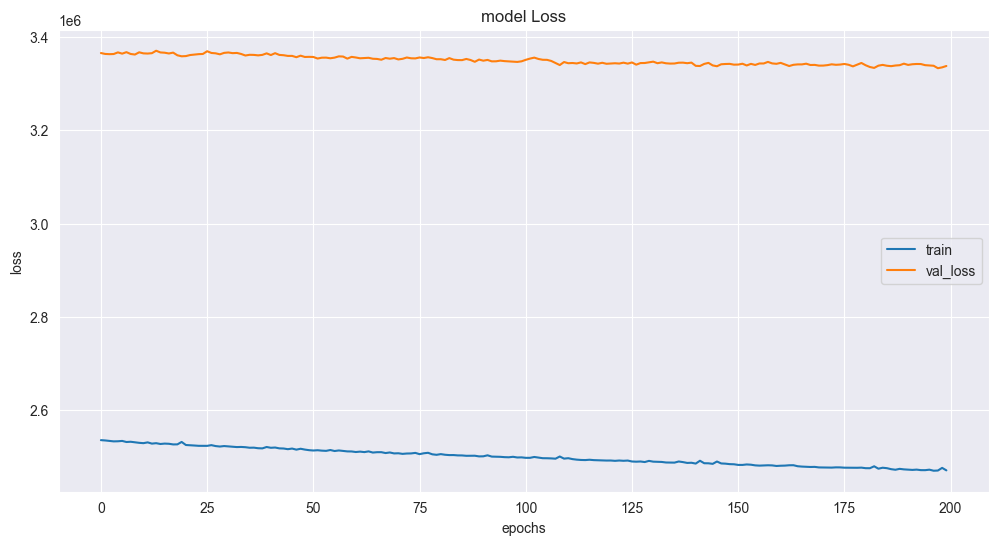

In [117]:
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model Loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','val_loss'])
plt.show()

In [102]:
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','accuracy'])
plt.show()

KeyError: 'accuracy'

<Figure size 1200x600 with 0 Axes>

In [104]:
history.history

{'loss': [21661300.0,
  10166176.0,
  7042027.5,
  5804647.5,
  5133829.0,
  4720718.0,
  4416360.5,
  4152114.25,
  3930504.75,
  3747017.75,
  3619088.5,
  3506640.75,
  3421669.5,
  3364633.75,
  3317097.5,
  3314789.75,
  3248322.0,
  3212639.5,
  3189060.75,
  3165810.5,
  3144925.0,
  3140843.0,
  3111362.0,
  3093884.0,
  3078968.0,
  3075319.25,
  3056567.75,
  3037380.5,
  3023929.0,
  3017988.0,
  3005983.0,
  2997724.5,
  2983778.25,
  2979259.25,
  2961239.25,
  2949345.75,
  2943969.0,
  2939932.5,
  2926039.75,
  2912839.0,
  2921368.25,
  2898717.5,
  2911657.25,
  2888941.0,
  2887187.25,
  2872311.5,
  2870911.5,
  2861596.75,
  2848301.5,
  2842770.25,
  2832963.75,
  2821440.5,
  2819388.25,
  2804730.0,
  2803039.5,
  2795882.0,
  2786737.25,
  2781707.5,
  2782863.25,
  2771822.0,
  2763615.0,
  2764384.75,
  2754748.75,
  2741518.0,
  2741045.5,
  2735569.75,
  2732023.0,
  2727058.5,
  2717037.25,
  2718903.0,
  2714523.5,
  2702588.5,
  2696355.75,
  2691983.5,


#### 2. 4 Evaluation du model

In [106]:
test = model.evaluate(X_test, y_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2913461.7500 - root_mean_squared_error: 4906731.5000


In [107]:
test

[2940480.25, 5205271.5]

#### Prédiction des Valeurs

In [108]:
y_pred = model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [109]:
y_pred.shape

(1262, 1)

### Comparaison des Resulat

In [110]:
y_pred[:5]

array([[25057628.],
       [27005908.],
       [33269554.],
       [17684786.],
       [20663430.]], dtype=float32)

In [111]:
y_test[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[19295374.],
       [25037250.],
       [34851852.],
       [13753796.],
       [26778508.]], dtype=float32)>

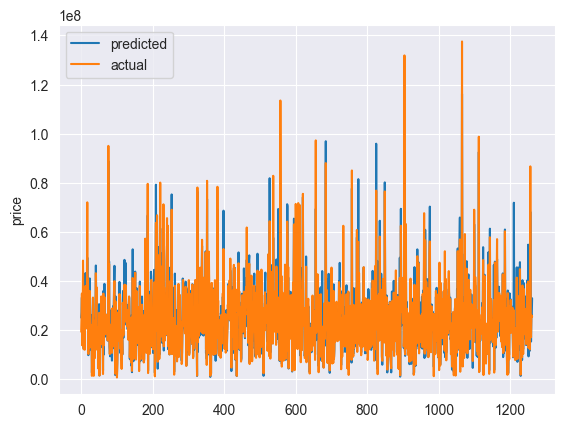

In [112]:
plt.plot(y_pred)
plt.plot(y_test)
plt.ylabel("price")
plt.legend(["predicted", "actual"])
plt.show()